# **SEL-NNML Random Search (RS) Tuning - Kaggle Heart Failure Prediction Dataset**

This notebook implements `Stacking Ensemble Learning with a Neural Network Meta-Learner (SEL-NNML)` model on the `Kaggle Heart Failure Prediction dataset (KHFPD)` .

## **0. Global Configuration**

In [1]:
# Random state for reproducibility
RANDOM_STATE = 42

# Data splitting configuration
TEST_SIZE = 0.2

# Cross-validation configuration
CV_FOLDS = 5

# Hyperparameter tuning configuration
OPTIMIZATION_ITERATIONS = 100
OPTIMIZATION_METRIC = 'accuracy'

# Parallel processing configuration
N_JOBS = -1 

# Dataset configuration
DATASET_PATH = '../../datasets/processed/ds1_kaggle_heart_clean.csv'
TARGET_COLUMN = 'HeartDisease'

print('Global configuration loaded successfully!')
print(f'Random State: {RANDOM_STATE}')
print(f'Test Size: {TEST_SIZE}')
print(f'CV Folds: {CV_FOLDS}')
print(f'Optimization Iterations: {OPTIMIZATION_ITERATIONS}')
print(f'Optimization Metric: {OPTIMIZATION_METRIC}')

Global configuration loaded successfully!
Random State: 42
Test Size: 0.2
CV Folds: 5
Optimization Iterations: 100
Optimization Metric: accuracy


## **1. Import Library**

In [2]:
import pandas as pd
import numpy as np
np.random.seed(RANDOM_STATE)
import matplotlib.pyplot as plt
import optuna as opt
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

## **2. Load Dataset**

In [3]:
df = pd.read_csv(DATASET_PATH)
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 17 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              746 non-null    int64  
 1   Sex                              746 non-null    bool   
 2   RestingBP                        746 non-null    int64  
 3   Cholesterol                      746 non-null    int64  
 4   FastingBS                        746 non-null    bool   
 5   MaxHR                            746 non-null    int64  
 6   ExerciseAngina                   746 non-null    bool   
 7   Oldpeak                          746 non-null    float64
 8   HeartDisease                     746 non-null    bool   
 9   ChestPainType_ATA                746 non-null    bool   
 10  ChestPainType_NAP                746 non-null    bool   
 11  RestingECG_Normal                746 non-null    bool   
 12  ST_Slope_Flat         

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,RestingECG_Normal,ST_Slope_Flat,ST_Slope_Up,Male_ST_Slope_Flat,ChestPainType_ASY_ST_Slope_Flat,Male_ChestPainType_ASY
0,40,True,140,289,False,172,False,0.0,False,True,False,True,False,True,False,False,False
1,49,False,160,180,False,156,False,1.0,True,False,True,True,True,False,False,False,False
2,37,True,130,283,False,98,False,0.0,False,True,False,False,False,True,False,False,False
3,48,False,138,214,False,108,True,1.5,True,False,False,True,True,False,False,True,False
4,54,True,150,195,False,122,False,0.0,False,False,True,True,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
741,45,True,110,264,False,132,False,1.2,True,False,False,True,True,False,True,False,False
742,68,True,144,193,True,141,False,3.4,True,False,False,True,True,False,True,True,True
743,57,True,130,131,False,115,True,1.2,True,False,False,True,True,False,True,True,True
744,57,False,130,236,False,174,False,0.0,True,True,False,False,True,False,False,False,False


## **3. Data Preparation**

- Split the data into desired training and testing
- After that, Scaling the data using Min-Max Normalization

In [4]:
# Split dataset
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [5]:
# Min-Max Scaling
# Separate numeric and boolean columns
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
bool_cols = X_train.select_dtypes(include=['bool', 'uint8']).columns  # includes one-hot from get_dummies

# Initialize scaler and fit_transform only on numeric data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train[num_cols])
X_test_scaled = scaler.transform(X_test[num_cols])

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_cols, index=X_test.index)

# Concatenate back with boolean features (without modification)
X_train = pd.concat([X_train_scaled, X_train[bool_cols]], axis=1)
X_test = pd.concat([X_test_scaled, X_test[bool_cols]], axis=1)

## **4. Base Model Hyperparameter Tuning with RS and Cross Validation**

In [6]:
# Base Model Hyperparameter Tuning with RS and CV Function
def base_model_tuning(model_name, x_train, y_train, iterations=100, metric_compare='accuracy'):
    if model_name == 'Logistic Regression':
        def objective(trial):
            solver = trial.suggest_categorical('solver', ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag'])
            C = trial.suggest_float('C', 1e-4, 10, log=True)
            model = LogisticRegression(solver=solver, C=C, max_iter=1000, random_state=RANDOM_STATE, n_jobs=N_JOBS)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='Random Fine Tuning: Logistic Regression', direction='maximize', sampler=opt.samplers.RandomSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = LogisticRegression(**best_params, max_iter=1000, random_state=RANDOM_STATE, n_jobs=N_JOBS)
    
    elif model_name == 'Decision Tree':
        def objective(trial):
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
            max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
            max_depth = trial.suggest_int('max_depth', 3, 10)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
            model = DecisionTreeClassifier(criterion=criterion, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=RANDOM_STATE)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()

        study = opt.create_study(study_name='Random Fine Tuning: Decision Tree', direction='maximize', sampler=opt.samplers.RandomSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = DecisionTreeClassifier(**best_params, random_state=RANDOM_STATE)
        
    elif model_name == 'Random Forest':
        def objective(trial):
            criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
            max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
            n_estimators = trial.suggest_int('n_estimators', 10, 100)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
            model = RandomForestClassifier(criterion=criterion, max_features=max_features, n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=RANDOM_STATE, n_jobs=N_JOBS)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='Random Fine Tuning: Random Forest', direction='maximize', sampler=opt.samplers.RandomSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = RandomForestClassifier(**best_params, random_state=RANDOM_STATE, n_jobs=N_JOBS)
    
    elif model_name == 'K-Nearest Neighbors':
        def objective(trial):
            algorithm = trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree', 'brute'])
            n_neighbors = trial.suggest_int('n_neighbors', 3, 50)
            p = trial.suggest_int('p', 1, 2)
            model = KNeighborsClassifier(weights='uniform', algorithm=algorithm, n_neighbors=n_neighbors, p=p, n_jobs=N_JOBS)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='Random Fine Tuning: K-Nearest Neighbors', direction='maximize', sampler=opt.samplers.RandomSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = KNeighborsClassifier(**best_params, weights='uniform', n_jobs=N_JOBS)
    
    elif model_name == 'Support Vector Machine':
        def objective(trial):
            kernel = trial.suggest_categorical('kernel', ['rbf', 'sigmoid', 'poly'])
            C = trial.suggest_float('C', 1e-4, 1e-2, log=True)
            degree = trial.suggest_int('degree', 2, 5) if kernel == 'poly' else 3
            model = SVC(kernel=kernel, gamma='scale', C=C, degree=degree, random_state=RANDOM_STATE)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='Random Fine Tuning: Support Vector Machine', direction='maximize', sampler=opt.samplers.RandomSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = SVC(**best_params, gamma='scale', random_state=RANDOM_STATE)
    
    elif model_name == 'AdaBoost':
        def objective(trial):
            n_estimators = trial.suggest_int('n_estimators', 10, 100)
            learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0, log=True)
            model = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=RANDOM_STATE)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='Random Fine Tuning: AdaBoost', direction='maximize', sampler=opt.samplers.RandomSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = AdaBoostClassifier(**best_params, random_state=RANDOM_STATE)
        
    elif model_name == 'Gradient Boosting':
        def objective(trial):
            max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
            n_estimators = trial.suggest_int('n_estimators', 10, 100)
            learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
            subsample = trial.suggest_float('subsample', 0.5, 1.0)
            model = GradientBoostingClassifier(criterion='friedman_mse', loss='log_loss', max_features=max_features, n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, subsample=subsample, random_state=RANDOM_STATE)
            return cross_val_score(model, x_train, y_train, cv=CV_FOLDS, scoring=metric_compare, n_jobs=N_JOBS).mean()
        
        study = opt.create_study(study_name='Random Fine Tuning: Gradient Boosting', direction='maximize', sampler=opt.samplers.RandomSampler(seed=RANDOM_STATE))
        study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
        best_params = study.best_params
        model = GradientBoostingClassifier(**best_params, criterion='friedman_mse', loss='log_loss', random_state=RANDOM_STATE)
    
    print(f'\nBest Hyperparameters for {model_name}: (Using RandomSampler)')
    print(best_params)
    
    return model

In [7]:
# Begin timing base models training
base_models_training_start = time.time()

### **4.1 Logistic Regression Hyperparameter Tuning**

In [8]:
logistic_regression = base_model_tuning('Logistic Regression', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

[I 2025-10-02 22:43:58,571] A new study created in memory with name: Random Fine Tuning: Logistic Regression


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:44:01,507] Trial 0 finished with value: 0.6459803921568629 and parameters: {'solver': 'newton-cg', 'C': 0.0006026889128682511}. Best is trial 0 with value: 0.6459803921568629.
[I 2025-10-02 22:44:03,716] Trial 1 finished with value: 0.850658263305322 and parameters: {'solver': 'newton-cholesky', 'C': 0.3470266988650412}. Best is trial 1 with value: 0.850658263305322.
[I 2025-10-02 22:44:06,180] Trial 2 finished with value: 0.7265686274509804 and parameters: {'solver': 'newton-cg', 'C': 0.0008111941985431928}. Best is trial 1 with value: 0.850658263305322.
[I 2025-10-02 22:44:08,139] Trial 3 finished with value: 0.8137394957983192 and parameters: {'solver': 'newton-cholesky', 'C': 0.0028585493941961923}. Best is trial 1 with value: 0.850658263305322.
[I 2025-10-02 22:44:08,187] Trial 4 finished with value: 0.8489775910364145 and parameters: {'solver': 'lbfgs', 'C': 0.019069966103000432}. Best is trial 1 with value: 0.850658263305322.
[I 2025-10-02 22:44:08,222] Trial 5 

### **4.2 Decision Tree Hyperparameter Tuning**

In [9]:
decision_tree = base_model_tuning('Decision Tree', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

[I 2025-10-02 22:44:12,726] A new study created in memory with name: Random Fine Tuning: Decision Tree


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:44:12,852] Trial 0 finished with value: 0.8137535014005601 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8137535014005601.
[I 2025-10-02 22:44:12,967] Trial 1 finished with value: 0.8104061624649859 and parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8137535014005601.
[I 2025-10-02 22:44:13,082] Trial 2 finished with value: 0.8087254901960785 and parameters: {'criterion': 'log_loss', 'max_features': None, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8137535014005601.
[I 2025-10-02 22:44:13,186] Trial 3 finished with value: 0.8271848739495798 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8271

### **4.3 Random Forest Hyperparameter Tuning**

In [10]:
random_forest = base_model_tuning('Random Forest', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

[I 2025-10-02 22:44:15,527] A new study created in memory with name: Random Fine Tuning: Random Forest


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:44:15,654] Trial 0 finished with value: 0.8372408963585434 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 15, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.8372408963585434.
[I 2025-10-02 22:44:15,795] Trial 1 finished with value: 0.8590756302521008 and parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'n_estimators': 37, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.8590756302521008.
[I 2025-10-02 22:44:15,926] Trial 2 finished with value: 0.8356022408963586 and parameters: {'criterion': 'gini', 'max_features': None, 'n_estimators': 28, 'max_depth': 7, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8590756302521008.
[I 2025-10-02 22:44:16,067] Trial 3 finished with value: 0.8456302521008402 and parameters: {'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 37, 'max_depth': 3, 'min_samples

### **4.4 K-Nearest Neighbors Hyperparameter Tuning**

In [11]:
knn = base_model_tuning('K-Nearest Neighbors', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

[I 2025-10-02 22:44:28,615] A new study created in memory with name: Random Fine Tuning: K-Nearest Neighbors


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:44:28,668] Trial 0 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 31, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-02 22:44:28,829] Trial 1 finished with value: 0.8523249299719888 and parameters: {'algorithm': 'brute', 'n_neighbors': 31, 'p': 2}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-02 22:44:28,876] Trial 2 finished with value: 0.8472969187675069 and parameters: {'algorithm': 'kd_tree', 'n_neighbors': 13, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-02 22:44:29,036] Trial 3 finished with value: 0.8489635854341737 and parameters: {'algorithm': 'brute', 'n_neighbors': 23, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-02 22:44:29,084] Trial 4 finished with value: 0.8489775910364145 and parameters: {'algorithm': 'ball_tree', 'n_neighbors': 20, 'p': 1}. Best is trial 0 with value: 0.8523249299719888.
[I 2025-10-02 22:44:29,130] Trial 5 f

### **4.5 Support Vector Machine Hyperparameter Tuning**

In [12]:
svm = base_model_tuning('Support Vector Machine', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

[I 2025-10-02 22:44:33,525] A new study created in memory with name: Random Fine Tuning: Support Vector Machine


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:44:33,572] Trial 0 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0015751320499779737}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-10-02 22:44:33,610] Trial 1 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.005399484409787433}. Best is trial 0 with value: 0.5352380952380952.
[I 2025-10-02 22:44:33,648] Trial 2 finished with value: 0.5453221288515406 and parameters: {'kernel': 'sigmoid', 'C': 0.008706020878304856}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-10-02 22:44:33,675] Trial 3 finished with value: 0.5352380952380952 and parameters: {'kernel': 'rbf', 'C': 0.00023270677083837802}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-10-02 22:44:33,701] Trial 4 finished with value: 0.5352380952380952 and parameters: {'kernel': 'sigmoid', 'C': 0.0003823475224675188}. Best is trial 2 with value: 0.5453221288515406.
[I 2025-10-02 22:44:33,728] Trial 5 finished with valu

### **4.6 Adaptive Boosting Hyperparameter Tuning**

In [13]:
adaboost = base_model_tuning('AdaBoost', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

[I 2025-10-02 22:44:36,527] A new study created in memory with name: Random Fine Tuning: AdaBoost


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:44:36,622] Trial 0 finished with value: 0.8422549019607842 and parameters: {'n_estimators': 44, 'learning_rate': 0.711447600934342}. Best is trial 0 with value: 0.8422549019607842.
[I 2025-10-02 22:44:36,751] Trial 1 finished with value: 0.84390756302521 and parameters: {'n_estimators': 76, 'learning_rate': 0.06251373574521749}. Best is trial 1 with value: 0.84390756302521.
[I 2025-10-02 22:44:36,800] Trial 2 finished with value: 0.8154621848739495 and parameters: {'n_estimators': 24, 'learning_rate': 0.0029375384576328283}. Best is trial 1 with value: 0.84390756302521.
[I 2025-10-02 22:44:36,836] Trial 3 finished with value: 0.8388795518207284 and parameters: {'n_estimators': 15, 'learning_rate': 0.39676050770529875}. Best is trial 1 with value: 0.84390756302521.
[I 2025-10-02 22:44:36,946] Trial 4 finished with value: 0.8489495798319326 and parameters: {'n_estimators': 64, 'learning_rate': 0.13311216080736885}. Best is trial 4 with value: 0.8489495798319326.
[I 2025-

### **4.7 Gradient Boosting Hyperparameter Tuning**

In [14]:
gradient_boosting = base_model_tuning('Gradient Boosting', X_train, y_train, iterations=OPTIMIZATION_ITERATIONS, metric_compare=OPTIMIZATION_METRIC)

[I 2025-10-02 22:44:47,108] A new study created in memory with name: Random Fine Tuning: Gradient Boosting


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-10-02 22:44:47,309] Trial 0 finished with value: 0.7985994397759104 and parameters: {'max_features': 'log2', 'n_estimators': 64, 'learning_rate': 0.0020513382630874496, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 9, 'subsample': 0.8005575058716043}. Best is trial 0 with value: 0.7985994397759104.
[I 2025-10-02 22:44:47,588] Trial 1 finished with value: 0.83890756302521 and parameters: {'max_features': None, 'n_estimators': 85, 'learning_rate': 0.0026587543983272706, 'max_depth': 4, 'min_samples_split': 3, 'min_samples_leaf': 4, 'subsample': 0.762378215816119}. Best is trial 1 with value: 0.83890756302521.
[I 2025-10-02 22:44:47,680] Trial 2 finished with value: 0.7028991596638656 and parameters: {'max_features': None, 'n_estimators': 22, 'learning_rate': 0.00383962929980417, 'max_depth': 5, 'min_samples_split': 6, 'min_samples_leaf': 8, 'subsample': 0.5998368910791798}. Best is trial 1 with value: 0.83890756302521.
[I 2025-10-02 22:44:47,821] Trial 3 finished wi

### **4.8 Save Best Model for each Base Models**

In [15]:
# Final Base Model Fitting
base_logistic_regression = logistic_regression.fit(X_train, y_train)
base_decision_tree = decision_tree.fit(X_train, y_train)
base_random_forest = random_forest.fit(X_train, y_train)
base_knn = knn.fit(X_train, y_train)
base_svm = svm.fit(X_train, y_train)
base_adaboost = adaboost.fit(X_train, y_train)
base_gradient_boosting = gradient_boosting.fit(X_train, y_train)

# End timing base models training
base_models_training_end = time.time()

# Save base models total training time
base_models_training_time = base_models_training_end - base_models_training_start

# Base Models Storage
base_models = {
    'Logistic Regression': base_logistic_regression,
    'Decision Tree': base_decision_tree,
    'Random Forest': base_random_forest,
    'K-Nearest Neighbors': base_knn,
    'Support Vector Machine': base_svm,
    'AdaBoost': base_adaboost,
    'Gradient Boosting': base_gradient_boosting
}

# Show Base Model Hyperparameters
base_model_hyperparameters = pd.DataFrame(columns=['Model Name', 'Best Hyperparameters'])
base_model_hyperparameters['Model Name'] = [
                                        'Logistic Regression', 
                                        'Decision Tree', 
                                        'Random Forest', 
                                        'K-Nearest Neighbors', 
                                        'Support Vector Machine', 
                                        'AdaBoost', 
                                        'Gradient Boosting'
                                        ]
base_model_hyperparameters['Best Hyperparameters'] = [   
                                                base_logistic_regression.get_params(),
                                                base_decision_tree.get_params(), 
                                                base_random_forest.get_params(), 
                                                base_knn.get_params(), 
                                                base_svm.get_params(), 
                                                base_adaboost.get_params(), 
                                                base_gradient_boosting.get_params(),
                                                ]

base_model_hyperparameters

,Model Name,Best Hyperparameters
0,Logistic Regression,"{'C': 0.09761125443110447, 'class_weight': Non..."
1,Decision Tree,"{'ccp_alpha': 0.0, 'class_weight': None, 'crit..."
2,Random Forest,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
3,K-Nearest Neighbors,"{'algorithm': 'brute', 'leaf_size': 30, 'metri..."
4,Support Vector Machine,"{'C': 0.008088298191148204, 'break_ties': Fals..."
5,AdaBoost,"{'algorithm': 'deprecated', 'estimator': None,..."
6,Gradient Boosting,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'..."


## **5. Meta Model Hyperparameter Tuning with RS and Cross Validation**

The hyperparameters to be tuned are:
- Selection of the number and type of base models used
- Number of layers in the neural network: 1 - 5
- Number of neurons per layer: 10 - 100
- Learning rate behavior: Constant or Adaptive
- Learning rate value: 0.0001 - 0.01
- L2 Regularization value: 0.0001 - 0.01

Unchanged Preset hyperparameters:
- Activation function: ReLU
- Optimizer (Solver): Adam
- Epochs (Max Iter): 300

In [16]:
# Meta Model (Stacking with MLP) Hyperparameter Tuning with RS and CV Function
def meta_model_tuning(models, x_train, y_train, x_test, y_test, iterations=100):
    def objective(trial):
        # Suggest which base models to include
        selected_estimators = []
        for name, model in models.items():
            use_model = trial.suggest_categorical(f'use_{name}', [True, False])
            if use_model:
                selected_estimators.append((name, model))
        # At least 2 base models required for stacking
        if len(selected_estimators) < 2:
            return 0.0

        n_layers = trial.suggest_int('n_layers', 1, 5)
        neurons = [trial.suggest_int(f'n_neurons_{i}', 10, 100) for i in range(n_layers)]
        learning_rate = trial.suggest_categorical('learning_rate', ['constant', 'adaptive'])
        learning_rate_init = trial.suggest_float('learning_rate_init', 0.0001, 0.01, log=True)
        alpha = trial.suggest_float('alpha', 0.0001, 0.01, log=True)

        meta_model = MLPClassifier(
            activation='relu',
            solver='adam',
            hidden_layer_sizes=tuple(neurons),
            learning_rate=learning_rate,
            learning_rate_init=learning_rate_init,
            alpha=alpha,
            max_iter=300,
            random_state=RANDOM_STATE
        )

        stacking_model = StackingClassifier(
            estimators=selected_estimators,
            final_estimator=meta_model,
            cv=CV_FOLDS,
            n_jobs=N_JOBS
        )

        stacking_model.fit(x_train, y_train)
        y_pred = stacking_model.predict(x_test)
        return accuracy_score(y_test, y_pred)

    study = opt.create_study(study_name='Meta Model Fine Tuning: Stacking with MLP (Random Search)', direction='maximize', sampler=opt.samplers.RandomSampler(seed=RANDOM_STATE))
    study.optimize(objective, n_trials=iterations, n_jobs=1, show_progress_bar=True)
    best_params = study.best_params

    # Get selected estimators from best_params
    best_selected_estimators = []
    for name, model in models.items():
        if best_params.get(f'use_{name}', False):
            best_selected_estimators.append((name, model))
            
    n_layers = best_params.pop('n_layers')
    hidden_layer_sizes = tuple(best_params.pop(f'n_neurons_{i}') for i in range(n_layers))
    best_params['hidden_layer_sizes'] = hidden_layer_sizes

    # Define the final meta model
    mlp_params = {k: v for k, v in best_params.items() if not k.startswith('use_')}
    best_meta_model = MLPClassifier(**mlp_params, activation='relu', solver='adam', max_iter=300, random_state=RANDOM_STATE)

    # Create the final stacking model using best_selected_estimators
    best_stacking_model = StackingClassifier(estimators=best_selected_estimators, final_estimator=best_meta_model, cv=CV_FOLDS, n_jobs=N_JOBS)

    print('\nBest Meta Model Hyperparameters:')
    print(best_meta_model.get_params())
    print('\nSelected Base Models for Stacking:')
    for name, _ in best_selected_estimators:
        print(f'- {name}')

    return best_stacking_model

In [17]:
# Begin timing meta model training
meta_model_training_start = time.time()

# Meta Model Tuning and Final Stacking Model Fitting
sel_nnml = meta_model_tuning(base_models, X_train, y_train, X_test, y_test, iterations=OPTIMIZATION_ITERATIONS)
sel_nnml.fit(X_train, y_train)

# End timing meta model training
meta_model_training_end = time.time()

# Save meta model training time
meta_model_training_time = meta_model_training_end - meta_model_training_start

[I 2025-10-02 22:45:14,108] A new study created in memory with name: Meta Model Fine Tuning: Stacking with MLP (Random Search)


  0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:45:15,791] Trial 0 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 26, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0007309539835912913, 'alpha': 0.0003823475224675188}. Best is trial 0 with value: 0.92.
[I 2025-10-02 22:45:17,870] Trial 1 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 83, 'n_neurons_1': 37, 'n_neurons_2': 18, 'n_neurons_3': 72, 'n_neurons_4': 50, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00011715937392307068, 'alpha': 0.006586289317583112}. Best is tr

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


[I 2025-10-02 22:45:23,023] Trial 2 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.004544383960336014, 'alpha': 0.0005170191786366995}. Best is trial 0 with value: 0.92.


c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:45:24,906] Trial 3 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 20, 'n_neurons_1': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00013400367243354819, 'alpha': 0.0004187594718900631}. Best is trial 0 with value: 0.92.
[I 2025-10-02 22:45:26,416] Trial 4 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 12, 'learning_rate': 'constant', 'learning_rate_init': 0.0010402587615883842, 'alpha': 0.006533305220227739}. Best is trial 4 with value: 0.9333333333333333.
[I 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:45:29,267] Trial 6 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 55, 'n_neurons_1': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.001656260589333597, 'alpha': 0.0010124137770478635}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:45:29,611] Trial 7 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 4, 'n_neurons_0': 58, 'n_neurons_1': 18, 'n_neurons_2': 86, 'n_neurons_3': 39, 'learning_rate': 'constant', 'learning_rate_init': 0.0015197980620034217, 'alpha': 0.002265

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:45:31,155] Trial 9 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 68, 'n_neurons_1': 17, 'n_neurons_2': 24, 'n_neurons_3': 91, 'learning_rate': 'constant', 'learning_rate_init': 0.00015956700210656633, 'alpha': 0.002123261760236048}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:45:32,066] Trial 10 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 43, 'learning_rate': 'constant', 'learning_rate_init': 0.008831228248242527, 'alpha': 0.0006112170343513632}. Best is trial 4 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:45:34,004] Trial 11 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 43, 'n_neurons_1': 11, 'n_neurons_2': 94, 'n_neurons_3': 48, 'n_neurons_4': 97, 'learning_rate': 'constant', 'learning_rate_init': 0.0003880590213919323, 'alpha': 0.0005891087281171029}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:45:34,977] Trial 12 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 73, 'n_neurons_1': 42, 'n_neurons_2': 36, 'n_neurons_3': 83, 'learning_rate': 'adaptive', 'lea

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:45:43,731] Trial 20 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 16, 'n_neurons_1': 84, 'n_neurons_2': 74, 'n_neurons_3': 17, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005604560885506443, 'alpha': 0.0005511683794624128}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:45:44,248] Trial 21 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 1, 'n_neurons_0': 20, 'learning_rate': 'adaptive', 'learning_rate_init': 0.003105201294430152, 'alpha': 0.0014680387869452154}. Best is trial 4 w

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:45:45,500] Trial 23 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 27, 'n_neurons_1': 52, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00014304387745680657, 'alpha': 0.008887704677237365}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:45:47,055] Trial 24 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 5, 'n_neurons_0': 14, 'n_neurons_1': 12, 'n_neurons_2': 44, 'n_neurons_3': 83, 'n_neurons_4': 99, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0005778055555902347, 'alpha':

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:45:56,021] Trial 32 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 48, 'n_neurons_1': 56, 'learning_rate': 'constant', 'learning_rate_init': 0.001664332465507855, 'alpha': 0.000377799263089713}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:45:57,097] Trial 33 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 52, 'n_neurons_1': 47, 'n_neurons_2': 41, 'learning_rate': 'constant', 'learning_rate_init': 0.008512435247428878, 'alpha': 0.0001772533479956596}. Best 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:45:58,585] Trial 34 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 42, 'n_neurons_1': 89, 'n_neurons_2': 45, 'learning_rate': 'constant', 'learning_rate_init': 0.0005673993825415947, 'alpha': 0.0008420920578362944}. Best is trial 4 with value: 0.9333333333333333.


c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:46:00,451] Trial 35 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 4, 'n_neurons_0': 66, 'n_neurons_1': 58, 'n_neurons_2': 91, 'n_neurons_3': 81, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00031403516315342447, 'alpha': 0.0030753360921253873}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:46:00,454] Trial 36 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': False}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:46:00,884] Trial 37 finished with value: 0.9066666666666666 and parameters: {'use_Logist

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:46:07,745] Trial 43 finished with value: 0.92 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 34, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003279256370202935, 'alpha': 0.00018998186562844776}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:46:08,656] Trial 44 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 22, 'learning_rate': 'constant', 'learning_rate_init': 0.001566124214205962, 'alpha': 0.001588670096363}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:46:09,936] 

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:46:24,393] Trial 62 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 26, 'n_neurons_1': 81, 'learning_rate': 'constant', 'learning_rate_init': 0.001290408163534379, 'alpha': 0.0027441228904630938}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:46:25,725] Trial 63 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 43, 'n_neurons_1': 99, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0014366494705598603, 'alpha': 0.0007537560974952886}. Best is trial 4 with value: 0.93333

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:46:30,650] Trial 69 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 89, 'n_neurons_1': 81, 'n_neurons_2': 61, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0006431031596032392, 'alpha': 0.00045088555611044626}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:46:30,654] Trial 70 finished with value: 0.0 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True}. Best is trial 4 with value: 0.9333333333333333.


c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:46:31,947] Trial 71 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 44, 'n_neurons_1': 46, 'learning_rate': 'constant', 'learning_rate_init': 0.0016436531848333894, 'alpha': 0.00338662042319669}. Best is trial 4 with value: 0.9333333333333333.


c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:46:33,301] Trial 72 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 33, 'n_neurons_1': 35, 'n_neurons_2': 37, 'learning_rate': 'constant', 'learning_rate_init': 0.0004193874191709548, 'alpha': 0.001662139868133609}. Best is trial 4 with value: 0.9333333333333333.


c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:46:35,109] Trial 73 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 60, 'n_neurons_1': 13, 'n_neurons_2': 67, 'n_neurons_3': 96, 'n_neurons_4': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0002858640510403272, 'alpha': 0.00026551537824360454}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:46:36,501] Trial 74 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 25, 'n_neurons_1': 77, 'n_neurons_2': 88, 'learning_rate': 'constant', 'learning_rate_init': 0.00011150059170

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:46:42,740] Trial 81 finished with value: 0.92 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 15, 'n_neurons_1': 73, 'n_neurons_2': 99, 'n_neurons_3': 31, 'n_neurons_4': 22, 'learning_rate': 'adaptive', 'learning_rate_init': 0.00015925446667814006, 'alpha': 0.002422828554185797}. Best is trial 4 with value: 0.9333333333333333.


c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:46:44,422] Trial 82 finished with value: 0.8933333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 85, 'n_neurons_1': 76, 'n_neurons_2': 80, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0009176737380720279, 'alpha': 0.00010924071993869074}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:46:45,671] Trial 83 finished with value: 0.9333333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 5, 'n_neurons_0': 18, 'n_neurons_1': 54, 'n_neurons_2': 23, 'n_neurons_3': 39, 'n_neurons_4': 77, 'learning_rate': 'constant', 'learning_rate_init':

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:46:48,171] Trial 85 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': False, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 1, 'n_neurons_0': 70, 'learning_rate': 'constant', 'learning_rate_init': 0.00011012601445612862, 'alpha': 0.0001459967993464517}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:46:49,218] Trial 86 finished with value: 0.9066666666666666 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': True, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 99, 'n_neurons_1': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.004202808250827565, 'alpha': 0.0020556880660352003}. Best is trial 4 with value: 0.93333333333

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:46:50,633] Trial 87 finished with value: 0.9266666666666666 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': True, 'use_Random Forest': False, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': True, 'n_layers': 2, 'n_neurons_0': 84, 'n_neurons_1': 88, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003195082233827963, 'alpha': 0.0032365614534194923}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:46:52,114] Trial 88 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': False, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': False, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': False, 'n_layers': 2, 'n_neurons_0': 56, 'n_neurons_1': 86, 'learning_rate': 'constant', 'learning_rate_init': 0.0015159866641908737, 'alpha': 0.0010392525381080842}. Best is trial 4 wi

c:\Users\azhar\miniconda3\envs\ml_kit\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:781: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


[I 2025-10-02 22:46:55,290] Trial 91 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': True, 'use_Gradient Boosting': True, 'n_layers': 3, 'n_neurons_0': 61, 'n_neurons_1': 61, 'n_neurons_2': 64, 'learning_rate': 'adaptive', 'learning_rate_init': 0.0003464506976855204, 'alpha': 0.004467852431220893}. Best is trial 4 with value: 0.9333333333333333.
[I 2025-10-02 22:46:56,200] Trial 92 finished with value: 0.9133333333333333 and parameters: {'use_Logistic Regression': True, 'use_Decision Tree': False, 'use_Random Forest': True, 'use_K-Nearest Neighbors': True, 'use_Support Vector Machine': True, 'use_AdaBoost': False, 'use_Gradient Boosting': False, 'n_layers': 3, 'n_neurons_0': 76, 'n_neurons_1': 100, 'n_neurons_2': 94, 'learning_rate': 'constant', 'learning_rate_init': 0.0018722107277466084, 'alpha': 0.003726

In [18]:
# All Models Storage (including Stacking Model)
all_models = {
    'Logistic Regression': base_logistic_regression,
    'Decision Tree': base_decision_tree,
    'Random Forest': base_random_forest,
    'K-Nearest Neighbors': base_knn,
    'Support Vector Machine': base_svm,
    'AdaBoost': base_adaboost,
    'Gradient Boosting': base_gradient_boosting,
    'SEL-NNML': sel_nnml
}

## **6. Model Evaluation**

This stage contains model evaluation on the test set, with details as follows:
- `plot_evaluation_metrics()`: Shows the confusion matrix graph & scores for accuracy, precision, recall, and F1-Score
- `Model Performance Comparison Plot`: Displays accuracy, precision, recall, F1-Score, and ROC AUC scores
- `overfitting_index_plot()`: Shows the percentage of the difference between model scores on test data versus training data

In [19]:
# Single Model Evaluation Dashboard
def evaluation_metrics_plot(y_true, y_pred):
    # Calculate metrics
    cm = confusion_matrix(y_true, y_pred)
    metrics = {
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred),
        'F1-Score': f1_score(y_true, y_pred),
    }
    metric_order = ['F1-Score', 'Recall', 'Precision', 'Accuracy']
    values = [metrics[name] for name in metric_order]

    fig = plt.figure(figsize=(10, 8))
    cm_pos = [0.08, 0.15, 0.53, 0.7]
    metrics_pos = [0.75, 0.15, 0.21, 0.7]

    # Confusion Matrix
    ax_cm = fig.add_axes(cm_pos)
    im = ax_cm.imshow(cm, cmap='Blues', interpolation='nearest', aspect='equal')
    cbar_ax = fig.add_axes([cm_pos[0] + cm_pos[2] + 0.02, cm_pos[1], 0.02, cm_pos[3]])
    fig.colorbar(im, cax=cbar_ax).ax.tick_params(labelsize=16)

    cm_pct = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count, pct = int(cm[i, j]), cm_pct[i, j]
            color = 'white' if count > cm.max() / 2 else 'black'
            ax_cm.text(j, i, f'{count}\n({pct:.1f}%)', ha='center', va='center',
                    color=color, fontsize=18, fontweight='bold', linespacing=1.1)

    ax_cm.set_xticks([0, 1])
    ax_cm.set_yticks([0, 1])
    ax_cm.set_xticklabels(['No\n(0)', 'Disease\n(1)'], fontsize=16)
    ax_cm.set_yticklabels(['No (0)', 'Disease (1)'], fontsize=16, rotation=90, va='center')
    ax_cm.set_xlabel('Predicted', fontsize=16, fontweight='bold')
    ax_cm.set_ylabel('Actual', fontsize=16, fontweight='bold')
    ax_cm.set_title('Confusion Matrix', fontsize=16, fontweight='bold', pad=10)
    ax_cm.set_ylim(1.5, -0.5)

    # Metrics Bar
    ax_metrics = fig.add_axes(metrics_pos)
    y_positions = np.arange(len(metric_order)) * 2
    bars = ax_metrics.barh(y_positions, values, height=0.8, color='#31688E', alpha=0.8)

    for bar, value in zip(bars, values):
        color = 'white' if value > 0.5 else 'black'
        x_pos = value - 0.02 if value > 0.5 else value + 0.02
        ha = 'right' if value > 0.5 else 'left'
        ax_metrics.text(x_pos, bar.get_y() + bar.get_height()/2, f'{value:.3f}',
                        ha=ha, va='center', fontsize=18, fontweight='bold', color=color)

    ax_metrics.set_xlim(-0.05, 1.05)
    ax_metrics.set_ylim(-0.8, len(metric_order) * 2 - 0.2)
    ax_metrics.set_xticks([0, 0.5, 1.0])
    ax_metrics.set_xticklabels(['0.0', '0.5', '1.0'], fontsize=16)
    ax_metrics.set_yticks(y_positions)
    ax_metrics.set_yticklabels(metric_order, fontsize=16, rotation=90, ha='left', va='center')
    ax_metrics.tick_params(axis='y', pad=15)
    ax_metrics.tick_params(axis='x', pad=8)
    ax_metrics.set_xlabel('Score', fontsize=16, fontweight='bold')
    ax_metrics.set_title('Performance Metrics', fontsize=16, fontweight='bold', pad=10)
    ax_metrics.grid(axis='x', alpha=0.3, linestyle='--')
    for spine in ['top', 'right', 'left']:
        ax_metrics.spines[spine].set_visible(False)
    ax_metrics.spines['bottom'].set_alpha(0.5)

    plt.show()


In [20]:
# Multiple Model Comparison Dashboard (for comparing all models)
def model_comparison_plot(models, x_test, y_test):
    metrics = {
        'Model': [],
        'Accuracy': [],
        'F1-Score': [],
        'Precision': [],
        'Recall': [],
        'AUC': []
    }
    
    # Map full names to short names
    short_names = {
        'Logistic Regression': 'LR',
        'Decision Tree': 'DT',
        'Random Forest': 'RF',
        'K-Nearest Neighbors': 'KNN',
        'Support Vector Machine': 'SVM',
        'AdaBoost': 'AdaBoost',
        'Gradient Boosting': 'Gradient Boosting',
        'SEL-NNML': 'SEL-NNML'
    }
    
    # Calculate metrics for each model
    for model_name, model in models.items():
        y_pred = model.predict(x_test)
        metrics['Model'].append(short_names[model_name])
        metrics['Accuracy'].append(accuracy_score(y_test, y_pred))
        metrics['F1-Score'].append(f1_score(y_test, y_pred))
        metrics['Precision'].append(precision_score(y_test, y_pred))
        metrics['Recall'].append(recall_score(y_test, y_pred))
        
        # Calculate AUC
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        metrics['AUC'].append(roc_auc)
    
    # Convert metrics to DataFrame for sorting
    metrics_df = pd.DataFrame(metrics)
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold') 
    
    # Helper function to plot sorted bar charts
    def plot_sorted_bar_chart(ax, metric_name):
        sorted_df = metrics_df.sort_values(by=metric_name, ascending=False)
        colors = ['tab:orange' if model == 'SEL-NNML' else 'tab:blue' for model in sorted_df['Model']]
        ax.bar(sorted_df['Model'], sorted_df[metric_name], color=colors)
        ax.set_title(metric_name)
        ax.set_ylabel('Score')
        ax.set_ylim([0, 1])
        ax.set_xticks(range(len(sorted_df['Model'])))
        ax.set_xticklabels(sorted_df['Model'], rotation=30, ha='center')
        for i, v in enumerate(sorted_df[metric_name]):
            ax.text(i, v + 0.01, f'{v:.3f}', ha='center')

    # Plot each metric
    plot_sorted_bar_chart(axes[0, 0], 'Accuracy')
    plot_sorted_bar_chart(axes[0, 1], 'F1-Score')
    plot_sorted_bar_chart(axes[1, 0], 'Precision')
    plot_sorted_bar_chart(axes[1, 1], 'Recall')
    
    # ROC Curve
    ax_roc = axes[2, 0]
    for model_name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(x_test)[:, 1]
        else:
            y_pred_proba = model.decision_function(x_test)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        ax_roc.plot(fpr, tpr, lw=2, label=f'{short_names[model_name]} (AUC = {roc_auc:.3f})')
    ax_roc.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    ax_roc.set_xlim([0.0, 1.0])
    ax_roc.set_ylim([0.0, 1.05])
    ax_roc.set_title('Receiver Operating Characteristic')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')
    ax_roc.legend(loc="lower right")
    
    # Bar chart for AUC
    plot_sorted_bar_chart(axes[2, 1], 'AUC')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


In [21]:
def overfitting_index_plot(all_models, x_train, y_train, x_test, y_test):
    metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
    overfitting_indices = {metric: [] for metric in metrics}

    for _, model in all_models.items():
        y_train_pred = model.predict(x_train)
        y_test_pred = model.predict(x_test)
        overfitting_indices['Accuracy'].append(abs(accuracy_score(y_train, y_train_pred) - accuracy_score(y_test, y_test_pred)) / accuracy_score(y_train, y_train_pred) * 100)
        overfitting_indices['F1-Score'].append(abs(f1_score(y_train, y_train_pred) - f1_score(y_test, y_test_pred)) / f1_score(y_train, y_train_pred) * 100)
        overfitting_indices['Precision'].append(abs(precision_score(y_train, y_train_pred) - precision_score(y_test, y_test_pred)) / precision_score(y_train, y_train_pred) * 100)
        overfitting_indices['Recall'].append(abs(recall_score(y_train, y_train_pred) - recall_score(y_test, y_test_pred)) / recall_score(y_train, y_train_pred) * 100)

    overfitting_df = pd.DataFrame(overfitting_indices, index=all_models.keys())

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Overfitting Index for All Metrics', fontsize=16, fontweight='bold')

    def get_bar_colors(models, highlight_model='SEL-NNML', default_color='tab:blue', highlight_color='tab:orange'):
        return [highlight_color if model == highlight_model else default_color for model in models]

    # Accuracy
    overfitting_df_sorted = overfitting_df.sort_values(by='Accuracy', ascending=False)
    axes[0, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Accuracy'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 0].set_title('Accuracy Overfitting Index')
    axes[0, 0].set_ylabel('Overfitting Index (%)')
    axes[0, 0].set_ylim([0, 100])
    axes[0, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Accuracy']):
        axes[0, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # F1-Score
    overfitting_df_sorted = overfitting_df.sort_values(by='F1-Score', ascending=False)
    axes[0, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['F1-Score'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[0, 1].set_title('F1-Score Overfitting Index')
    axes[0, 1].set_ylabel('Overfitting Index (%)')
    axes[0, 1].set_ylim([0, 100])
    axes[0, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['F1-Score']):
        axes[0, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    # Precision
    overfitting_df_sorted = overfitting_df.sort_values(by='Precision', ascending=False)
    axes[1, 0].bar(overfitting_df_sorted.index, overfitting_df_sorted['Precision'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 0].set_title('Precision Overfitting Index')
    axes[1, 0].set_ylabel('Overfitting Index (%)')
    axes[1, 0].set_ylim([0, 100])
    axes[1, 0].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Precision']):
        axes[1, 0].text(i, v + 1, f'{v:.2f}', ha='center')

    # Recall
    overfitting_df_sorted = overfitting_df.sort_values(by='Recall', ascending=False)
    axes[1, 1].bar(overfitting_df_sorted.index, overfitting_df_sorted['Recall'], 
                    color=get_bar_colors(overfitting_df_sorted.index))
    axes[1, 1].set_title('Recall Overfitting Index')
    axes[1, 1].set_ylabel('Overfitting Index (%)')
    axes[1, 1].set_ylim([0, 100])
    axes[1, 1].tick_params(axis='x', rotation=30)
    for i, v in enumerate(overfitting_df_sorted['Recall']):
        axes[1, 1].text(i, v + 1, f'{v:.2f}', ha='center')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### **6.1 Single Model Evaluation**

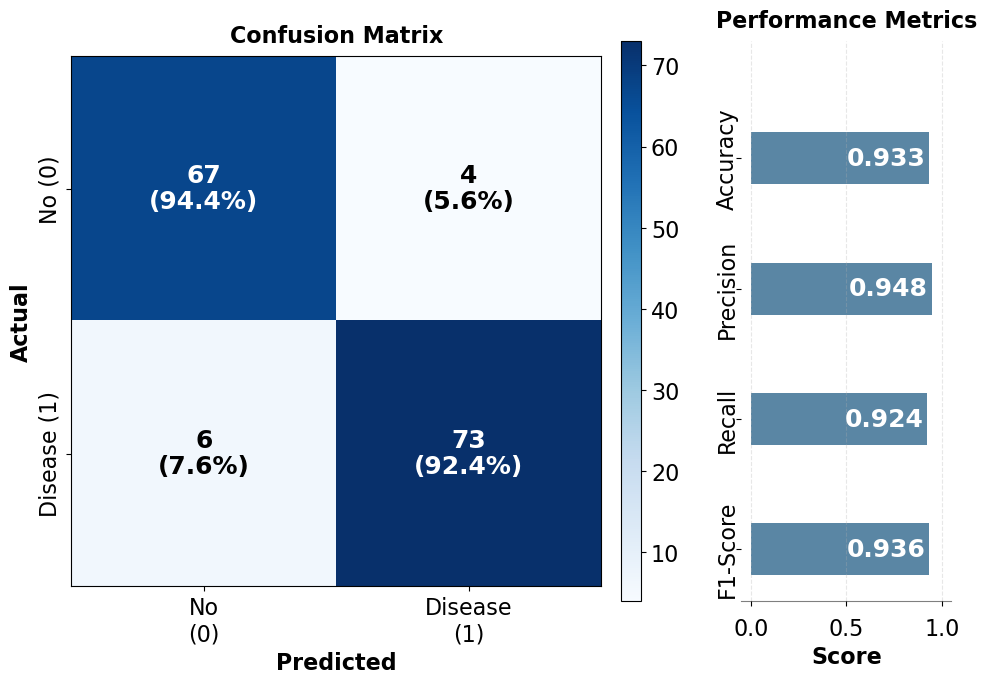

In [22]:
# Show SEL-NNML Evaluation Metrics
y_pred_stack = sel_nnml.predict(X_test)
evaluation_metrics_plot(y_test, y_pred_stack)

In [23]:
# Show SEL-NNM: all fold scores with mean and std 
sel_nnml_cv_scores = cross_val_score(sel_nnml, X_train, y_train, cv=CV_FOLDS, scoring='accuracy', n_jobs=N_JOBS)
print(f'SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: {sel_nnml_cv_scores}')
print(f'Mean: {sel_nnml_cv_scores.mean():.4f}')
print(f'Standard Deviation: {sel_nnml_cv_scores.std():.4f}')

SEL-NNML CV Accuracy Scores [Fold 1, Fold 2, ..., Fold n]: [0.85       0.8907563  0.88235294 0.82352941 0.88235294]
Mean: 0.8658
Standard Deviation: 0.0253


In [24]:
# Show SELL-NNML Training Time
Total_training_time = base_models_training_time + meta_model_training_time
print(f'Base Models Tuning & Training Time: {base_models_training_time:.2f} seconds')
print(f'Meta Model Tuning & Training Time: {meta_model_training_time:.2f} seconds')
print(f'Total SEL-NNML Tuning & Training Time: {Total_training_time:.2f} seconds')

Base Models Tuning & Training Time: 75.50 seconds
Meta Model Tuning & Training Time: 108.94 seconds
Total SEL-NNML Tuning & Training Time: 184.44 seconds


### **6.2 Multiple Model Evaluation**

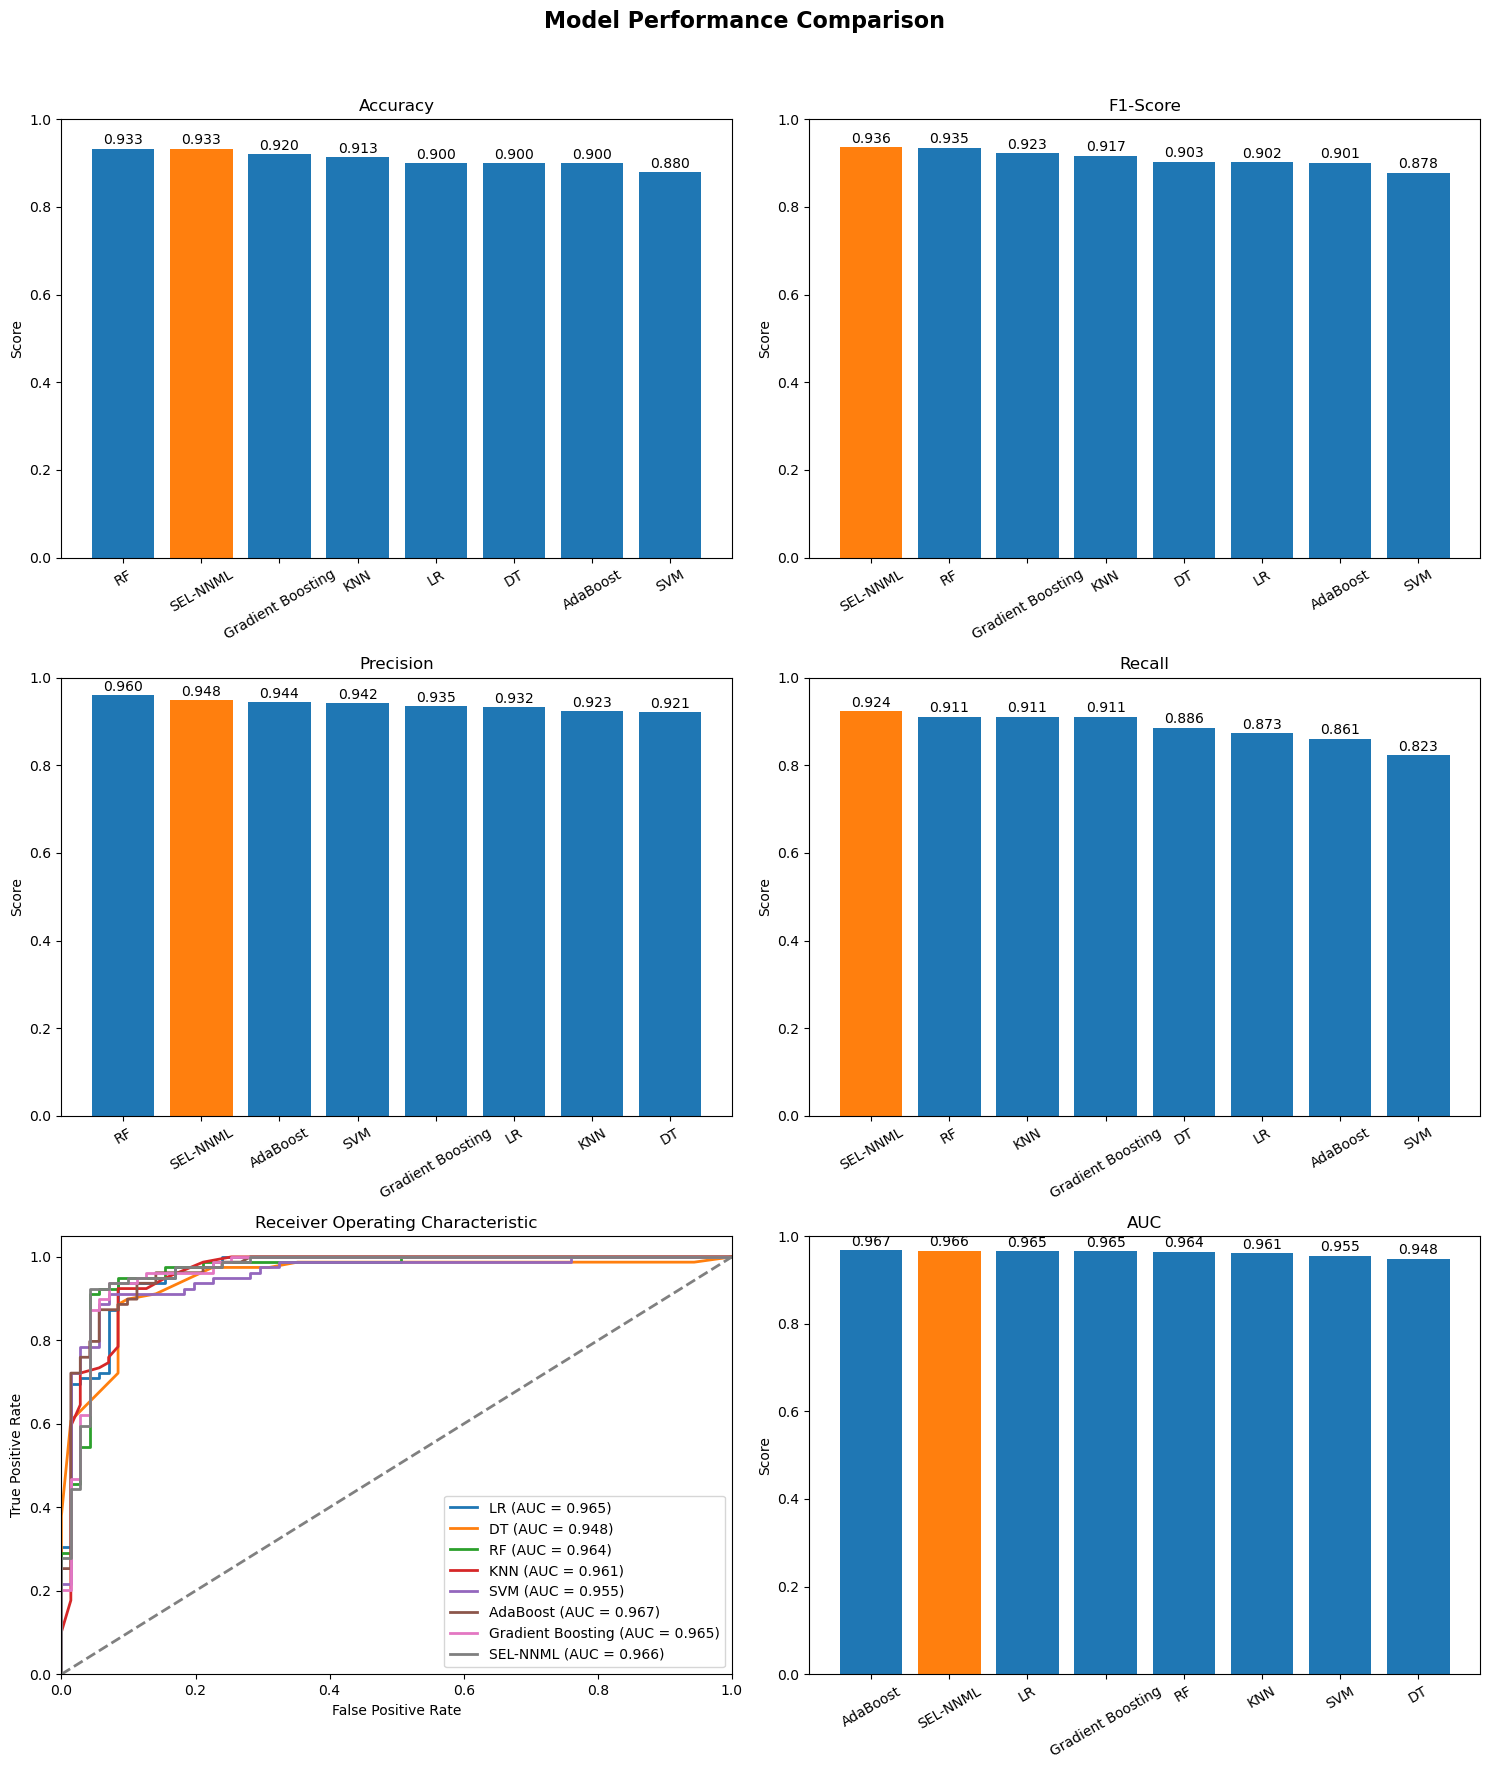

In [25]:
model_comparison_plot(all_models, X_test, y_test)

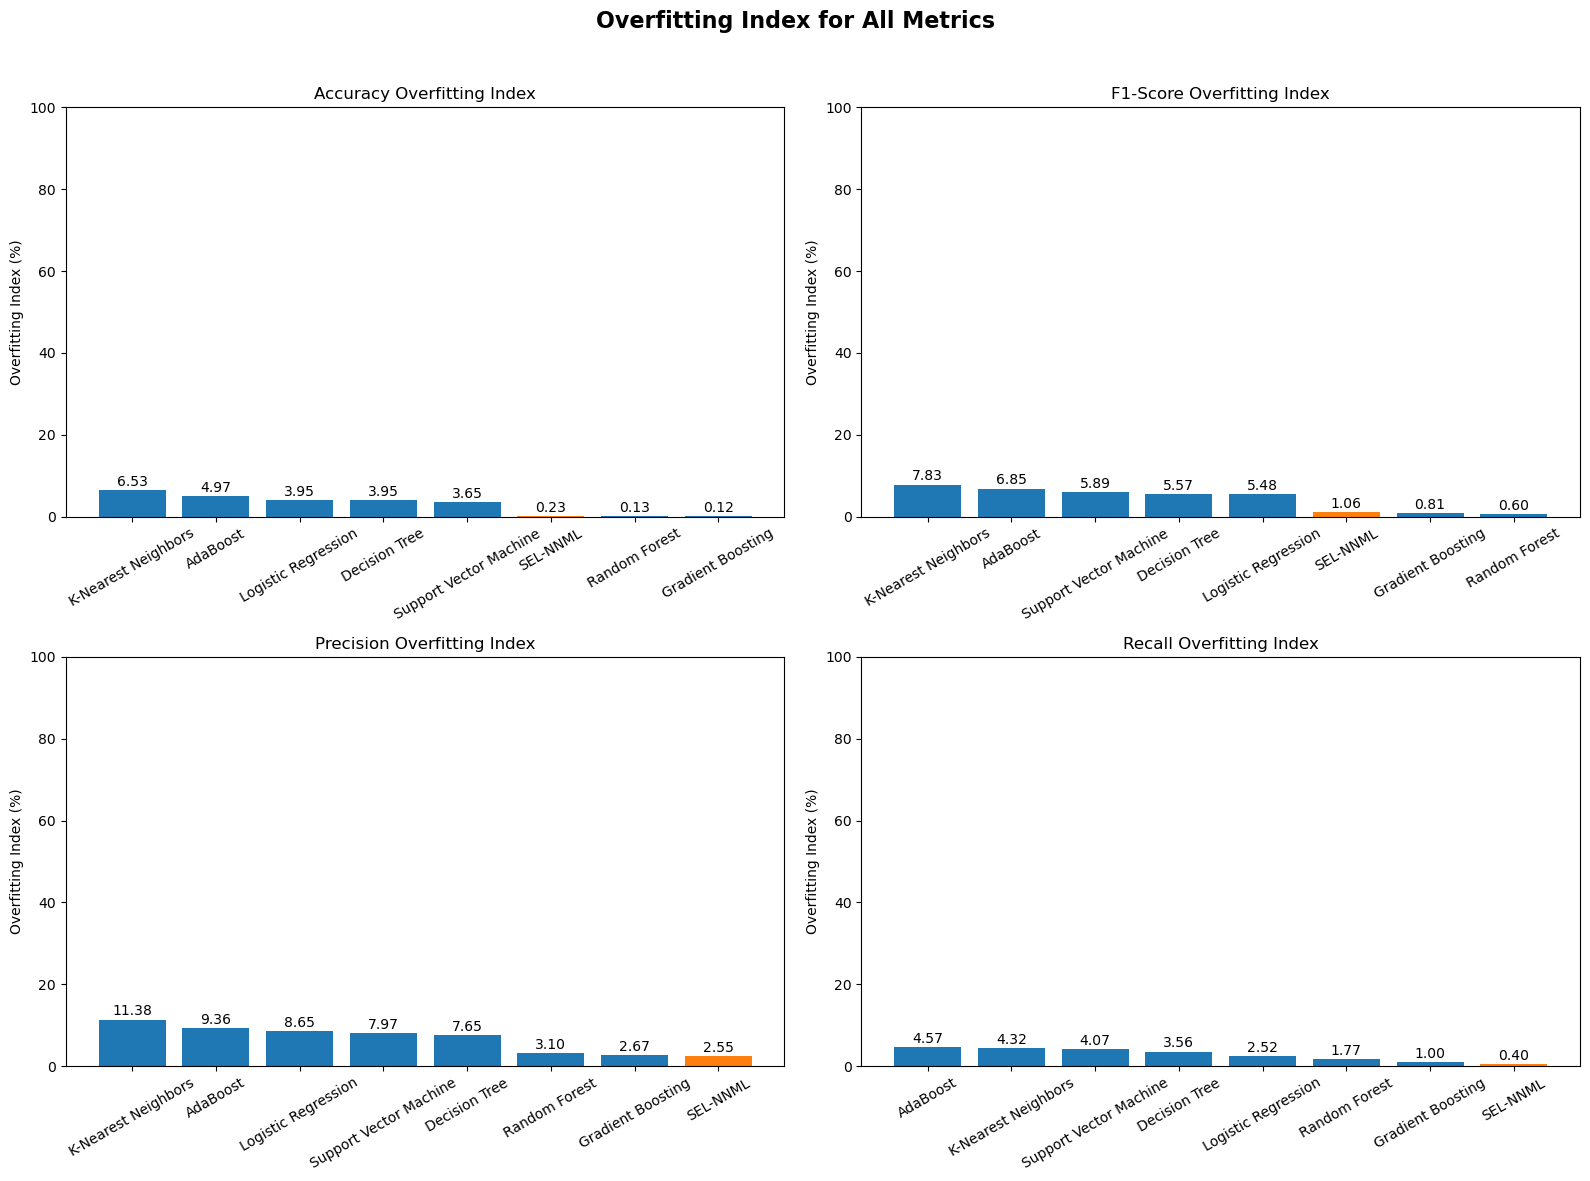

In [26]:
overfitting_index_plot(all_models, X_train, y_train, X_test, y_test)